In [1]:
import scanpy as sc
import scanpy.external as sce

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import median_abs_deviation as mad

import senepy as sp

In [162]:
from matplotlib.pyplot import rc_context

In [2]:

import celloracle as co
from celloracle.applications import Pseudotime_calculator
from celloracle.applications import Gradient_calculator
from celloracle.applications import Oracle_development_module

/home/jrlab/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/jrlab/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/

In [3]:
%matplotlib inline

In [2]:
ls ../data/kras_titration/sc_hepato/

GSE222338_RAW.tar
GSE222338_sample_hashtag_mapping.txt.gz
GSM6921240_Lib1_GeneExpression_barcodes.tsv.gz
GSM6921240_Lib1_GeneExpression_features.tsv.gz
GSM6921240_Lib1_GeneExpression_matrix.mtx.gz
GSM6921241_Lib2_GeneExpression_barcodes.tsv.gz
GSM6921241_Lib2_GeneExpression_features.tsv.gz
GSM6921241_Lib2_GeneExpression_matrix.mtx.gz
GSM6921242_Lib1_Hashtag_barcodes.tsv.gz
GSM6921242_Lib1_Hashtag_features.tsv.gz
GSM6921242_Lib1_Hashtag_matrix.mtx.gz
GSM6921243_Lib2_Hashtag_barcodes.tsv.gz
GSM6921243_Lib2_Hashtag_features.tsv.gz
GSM6921243_Lib2_Hashtag_matrix.mtx.gz


In [ ]:
#GSM6921240_Lib1_GeneExpression_
#GSM6921241_Lib2_GeneExpression_
#GSM6921242_Lib1_Hashtag_
#GSM6921243_Lib2_Hashtag_

In [149]:
bc_trans = pd.read_table('/home/jrlab/software/cellranger-7.2.0/lib/python/cellranger/barcodes/translation/3M-february-2018.txt.gz',
                        header = None)

In [181]:
bc_trans = dict(zip(bc_trans[0], bc_trans[1])) #both columns contain all bc doesnt matter order

In [52]:
#need to modify hashtag files to open with read_10x_mtx

def mod_hash_features(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None)
    df.insert(1, 'Duplicate', df.iloc[:, 0])
    df['Gene Expression'] = 'Gene Expression'
    df.to_csv(file_path, sep='\t', index=False, header=False, compression='gzip') 

In [53]:
#dont run twice
#mod_hash_features('../data/kras_titration/sc_hepato/GSM6921242_Lib1_Hashtag_features.tsv.gz')
#mod_hash_features('../data/kras_titration/sc_hepato/GSM6921243_Lib2_Hashtag_features.tsv.gz')

In [191]:
def load_hash(prefix):
    adata = sc.read_10x_mtx('../data/kras_titration/sc_hepato/', prefix = prefix)

    hashs = adata.var_names.map(lambda x: x.split('-')[0])
    adata.obs = pd.DataFrame(adata.X.toarray(), columns=hashs, index=adata.obs_names)

    hashs = [x for x in hashs if x != 'unmapped']
    
    sce.pp.hashsolo(adata, hashs)

    adata.obs['gex_bc'] = adata.obs.index.map(lambda x: bc_trans[x] + '-1')

    return adata


In [192]:
ah = load_hash('GSM6921242_Lib1_Hashtag_')
bh = load_hash('GSM6921243_Lib2_Hashtag_')

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


In [193]:
ah.obs

mV_A  mV_B  D12_A   D12_B   D30_A   D30_B  Tumour_A  \
GTGGCGTAGCGTGGCA   0.0  28.0    3.0    17.0     7.0  2099.0       2.0   
GATCCCTTCAGAATCT   3.0  29.0    6.0  3882.0     5.0    16.0      19.0   
ATGCGATGTAGGTCAG   1.0  28.0    8.0    15.0    10.0    11.0    2399.0   
TTCCTAAAGATGGGAG   0.0  17.0    4.0    15.0     6.0     9.0       4.0   
AAGTGAAGTGTGTGGA   0.0  26.0    6.0    11.0     1.0     8.0     162.0   
...                ...   ...    ...     ...     ...     ...       ...   
CCACACTAGATCTACT   2.0  18.0   17.0    27.0  6519.0    48.0       2.0   
TCACGCTCAACCTGTA   0.0  22.0    3.0     9.0    10.0    65.0       5.0   
TCATTTGAGGCTAATG   0.0  24.0    6.0    10.0     9.0  1389.0       3.0   
CTTCGGTCAACCCACG   2.0  13.0    0.0    10.0     7.0    11.0     702.0   
GACAGCCCATCATCTT   1.0  25.0    7.0   107.0     7.0    16.0       1.0   

                  Tumour_B  NonTumour_A  NonTumour_B  unmapped  \
GTGGCGTAGCGTGGCA       3.0          9.0          4.0      79.0   
GATCCCTTCAGAATCT       1.0          6.0          6.0     120.0   
ATGCGATGTAGGTCAG       4.0          4.0          7.0      89.0   
TTCCTAAAGATGGGAG       6.0          6.0          3.0       9.0   
AAGTGAAGTGTGTGGA       3.0          5.0          1.0       6.0   
...                    ...          ...          ...       ...   
CCACACTAGATCTACT       5.0          1.0          1.0     212.0   
TCACGCTCAACCTGTA     102.0          2.0          4.0      13.0   
TCATTTGAGGCTAATG       1.0          7.0          3.0      50.0   
CTTCGGTCAACCCACG       7.0          3.0          7.0      35.0   
GACAGCCCATCATCTT       1.0          3.0          7.0       8.0   

                  most_likely_hypothesis  cluster_feature  \
GTGGCGTAGCGTGGCA                     1.0              0.0   
GATCCCTTCAGAATCT                     1.0              0.0   
ATGCGATGTAGGTCAG                     1.0              0.0   
TTCCTAAAGATGGGAG                     1.0              0.0   
AAGTGAAGTGTGTGGA                     1.0              0.0   
...                                  ...              ...   
CCACACTAGATCTACT                     1.0              0.0   
TCACGCTCAACCTGTA                     2.0              0.0   
TCATTTGAGGCTAATG                     1.0              0.0   
CTTCGGTCAACCCACG                     1.0              0.0   
GACAGCCCATCATCTT                     1.0              0.0   

                  negative_hypothesis_probability  \
GTGGCGTAGCGTGGCA                     5.502273e-12   
GATCCCTTCAGAATCT                     1.260873e-14   
ATGCGATGTAGGTCAG                     2.568950e-12   
TTCCTAAAGATGGGAG                     4.171326e-02   
AAGTGAAGTGTGTGGA                     3.708649e-04   
...                                           ...   
CCACACTAGATCTACT                     8.194406e-17   
TCACGCTCAACCTGTA                     1.369520e-05   
TCATTTGAGGCTAATG                     2.452311e-10   
CTTCGGTCAACCCACG                     6.779362e-08   
GACAGCCCATCATCTT                     4.144659e-03   

                  singlet_hypothesis_probability  \
GTGGCGTAGCGTGGCA                        0.927453   
GATCCCTTCAGAATCT                        0.924907   
ATGCGATGTAGGTCAG                        0.927453   
TTCCTAAAGATGGGAG                        0.954224   
AAGTGAAGTGTGTGGA                        0.931781   
...                                          ...   
CCACACTAGATCTACT                        0.832178   
TCACGCTCAACCTGTA                        0.439910   
TCATTTGAGGCTAATG                        0.936229   
CTTCGGTCAACCCACG                        0.944938   
GACAGCCCATCATCTT                        0.930378   

                  doublet_hypothesis_probability Classification  \
GTGGCGTAGCGTGGCA                        0.072547          D30_B   
GATCCCTTCAGAATCT                        0.075093          D12_B   
ATGCGATGTAGGTCAG                        0.072547       Tumour_A   
TTCCTAAAGATGGGAG                        0.004063           mV_B   
AAGTGAAGTGTGTGGA  

In [194]:
bh.obs

mV_A  mV_B  D12_A  D12_B   D30_A  D30_B  Tumour_A  Tumour_B  \
TCAGCCTTCGAATTAC   1.0  40.0    5.0   16.0     4.0   19.0       1.0    2435.0   
CATGGATAGTGCGGAC   0.0  35.0    4.0   14.0  1915.0   23.0       1.0       8.0   
TGTCCTGCAAACATAG   0.0  38.0    1.0  223.0     6.0   12.0       0.0       2.0   
ACGATGTTCAGGGTGG   0.0  19.0    0.0    7.0    10.0   12.0      12.0       3.0   
TAATCTCAGCCAGCGA   0.0  24.0    1.0   24.0    11.0   13.0       5.0     853.0   
...                ...   ...    ...    ...     ...    ...       ...       ...   
AGCCAGCTCTTCCGGC   0.0  17.0    6.0    5.0  1246.0   10.0       2.0       5.0   
GGGTGAAGTGGAATAT   1.0  22.0  235.0   12.0    12.0   18.0       4.0       2.0   
ACGTCCTAGCATGCAA   1.0  21.0    1.0   99.0     3.0  641.0       3.0       1.0   
CAACGGCCATCTCGTC   0.0  40.0   11.0  588.0    15.0   33.0       4.0       2.0   
ATTCAGGCACCTTTGC   0.0  28.0   15.0   18.0  2524.0   37.0       1.0       7.0   

                  NonTumour_A  NonTumour_B  unmapped  most_likely_hypothesis  \
TCAGCCTTCGAATTAC          2.0          1.0      87.0                     1.0   
CATGGATAGTGCGGAC          1.0          4.0      51.0                     1.0   
TGTCCTGCAAACATAG          2.0          1.0      16.0                     1.0   
ACGATGTTCAGGGTGG         16.0          2.0       3.0                     1.0   
TAATCTCAGCCAGCGA         11.0          3.0      24.0                     1.0   
...                       ...          ...       ...                     ...   
AGCCAGCTCTTCCGGC          2.0          7.0      31.0                     1.0   
GGGTGAAGTGGAATAT          2.0          4.0      13.0                     1.0   
ACGTCCTAGCATGCAA          1.0          1.0      22.0                     2.0   
CAACGGCCATCTCGTC          2.0          4.0      29.0                     1.0   
ATTCAGGCACCTTTGC          8.0          2.0      55.0                     1.0   

                  cluster_feature  negative_hypothesis_probability  \
TCAGCCTTCGAATTAC              0.0                     1.561320e-05   
CATGGATAGTGCGGAC              0.0                     1.300888e-05   
TGTCCTGCAAACATAG              0.0                     2.064647e-03   
ACGATGTTCAGGGTGG              0.0                     4.679296e-03   
TAATCTCAGCCAGCGA              0.0                     4.171142e-09   
...                           ...                              ...   
AGCCAGCTCTTCCGGC              0.0                     3.917955e-05   
GGGTGAAGTGGAATAT              0.0                     1.649446e-03   
ACGTCCTAGCATGCAA              0.0                     5.218519e-09   
CAACGGCCATCTCGTC              0.0                     2.670613e-04   
ATTCAGGCACCTTTGC              0.0                     1.122447e-09   

                  singlet_hypothesis_probability  \
TCAGCCTTCGAATTAC                        0.813566   
CATGGATAGTGCGGAC                        0.828839   
TGTCCTGCAAACATAG                        0.817959   
ACGATGTTCAGGGTGG                        0.994497   
TAATCTCAGCCAGCGA                        0.969935   
...                                          ...   
AGCCAGCTCTTCCGGC                        0.886478   
GGGTGAAGTGGAATAT                        0.868598   
ACGTCCTAGCATGCAA                        0.188402   
CAACGGCCATCTCGTC                        0.813361   
ATTCAGGCACCTTTGC                        0.952787   

                  doublet_hypothesis_probability Classification  \
TCAGCCTTCGAATTAC                        0.186418       Tumour_B   
CATGGATAGTGCGGAC                        0.171148          D30_A   
TGTCCTGCAAACATAG                        0.179976          D12_B   
ACGATGTTCAGGGTGG                        0.000824           mV_B   
TAATCTCAGCCAGCGA                        0.030065       Tumour_B   
...                                          ...            ...   
AGCCAGCTCTTCCGGC                        0.113483          D30_A   
GGGTGAAGTGGAATAT                        0.129752          D12_A   
ACGTCCTAGCATGCA

In [196]:
ah2c = dict(zip(ah.obs.gex_bc, ah.obs.Classification))
bh2c = dict(zip(bh.obs.gex_bc, bh.obs.Classification))

In [276]:
def qc(adata, hasher = None):
    if hasher != None:
        adata.obs['Sample'] = adata.obs.index.map(hasher)
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top=[20], log1p=True, inplace = True)
    return adata

In [90]:
'''
Returns true if a given cell is a MAD outlier
'''
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]

    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))

    return (M > np.median(M) + nmads * mad(M))


'''
labels outlier cells from an individual anndata object
'''
def pp(adata):
    sc.pp.filter_cells(adata, min_genes = 200) #real cells really shouldn't have this few genes. Unless data very sparse

    #here we are summing bool. ie. False + False = False, True + True = True, False + True = True
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 5, upper_only = True)

    #adata = adata[~bool_vector] #we want to keep the ones that are false, ie, not MAD outliers
    adata.obs['Outlier'] = bool_vector

    adata = adata[adata.obs.pct_counts_mt < 25] #just in case any made it, typically 25% is very high

    return adata


def dd(adata):
    adata = adata.copy()
    sc.pp.scrublet(adata, expected_doublet_rate = 0.05)
    return adata

In [197]:
a = sc.read_10x_mtx('../data/kras_titration/sc_hepato/', prefix = 'GSM6921240_Lib1_GeneExpression_')
a = qc(a, ah2c)
a = pp(a)
a = dd(a)

In [198]:
b = sc.read_10x_mtx('../data/kras_titration/sc_hepato/', prefix = 'GSM6921241_Lib2_GeneExpression_')
b = qc(b, bh2c)
b = pp(b)
b = dd(b)

In [206]:
print(len(a), 'total')
print(len(a[a.obs.Outlier]), 'outliers')
print(len(a[a.obs.predicted_doublet]), 'scrublet')
print(len(a[a.obs.Sample == 'Doublet']), 'scsolo')
print(len(a[~(a.obs.Outlier) & ~(a.obs.predicted_doublet) & (a.obs.Sample != 'Doublet')]), 'total')

2604 total
191 outliers
4 scrublet
321 scsolo
2120 total


In [207]:
print(len(b), 'total')
print(len(b[b.obs.Outlier]), 'outliers')
print(len(b[b.obs.predicted_doublet]), 'scrublet')
print(len(b[b.obs.Sample == 'Doublet']), 'scsolo')
print(len(b[~(b.obs.Outlier) & ~(b.obs.predicted_doublet) & (b.obs.Sample != 'Doublet')]), 'total')

3429 total
236 outliers
1 scrublet
289 scsolo
2923 total


In [201]:
a.obs

Sample  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCCACAAGTATCC-1     D30_A                772                 6.650279   
AAACCCAGTTGTCTAG-1     D30_A                668                 6.505784   
AAACGAACAATAAGGT-1     D12_A                964                 6.872128   
AAACGAAGTATGGTAA-1     D12_B               2725                 7.910591   
AAACGAAGTCCTCAGG-1  Tumour_B                506                 6.228511   
...                      ...                ...                      ...   
TTTGATCGTAAGTTAG-1     D12_A                789                 6.672033   
TTTGATCTCACCATAG-1     D30_A               8065                 8.995413   
TTTGGTTGTACGGTTT-1     D30_B               1816                 7.504942   
TTTGGTTTCGCTAATG-1     D30_B                645                 6.470800   
TTTGTTGCAAGTGCAG-1     D30_A               5667                 8.642592   

                    total_counts  log1p_total_counts  \
AAACCCACAAGTATCC-1        1615.0            7.387709   
AAACCCAGTTGTCTAG-1        4011.0            8.297045   
AAACGAACAATAAGGT-1        2300.0            7.741099   
AAACGAAGTATGGTAA-1       12874.0            9.463042   
AAACGAAGTCCTCAGG-1        1011.0            6.919684   
...                          ...                 ...   
TTTGATCGTAAGTTAG-1        1389.0            7.237059   
TTTGATCTCACCATAG-1      116703.0           11.667397   
TTTGGTTGTACGGTTT-1        3865.0            8.259975   
TTTGGTTTCGCTAATG-1        1206.0            7.095893   
TTTGTTGCAAGTGCAG-1       45063.0           10.715839   

                    pct_counts_in_top_20_genes  total_counts_mt  \
AAACCCACAAGTATCC-1                   25.139319             18.0   
AAACCCAGTTGTCTAG-1                   44.178509            132.0   
AAACGAACAATAAGGT-1                   29.695652             75.0   
AAACGAAGTATGGTAA-1                   25.609756            359.0   
AAACGAAGTCCTCAGG-1                   34.025717              0.0   
...                                        ...              ...   
TTTGATCGTAAGTTAG-1                   22.534197             17.0   
TTTGATCTCACCATAG-1                   17.356023           4875.0   
TTTGGTTGTACGGTTT-1                   23.182406            126.0   
TTTGGTTTCGCTAATG-1                   29.933665             46.0   
TTTGTTGCAAGTGCAG-1                   20.040832           1037.0   

                    log1p_total_counts_mt  pct_counts_mt  n_genes  Outlier  \
AAACCCACAAGTATCC-1               2.944439       1.114551      772    False   
AAACCCAGTTGTCTAG-1               4.890349       3.290950      668    False   
AAACGAACAATAAGGT-1               4.330733       3.260870      964    False   
AAACGAAGTATGGTAA-1               5.886104       2.788566     2725    False   
AAACGAAGTCCTCAGG-1               0.000000       0.000000      506    False   
...                                   ...            ...      ...      ...   
TTTGATCGTAAGTTAG-1               2.890372       1.223902      789    False   
TTTGATCTCACCATAG-1               8.492081       4.177270     8065    False   
TTTGGTTGTACGGTTT-1               4.844187       3.260026     1816    False   
TTTGGTTTCGCTAATG-1               3.850148       3.814262      645    False   
TTTGTTGCAAGTGCAG-1               6.945051       2.301223     5667    False   

                    doublet_score  predicted_doublet  
AAACCCACAAGTATCC-1       0.042017              False  
AAACCCAGTTGTCTAG-1       0.024421              False  
AAACGAACAATAAGGT-1       0.064877              False  
AAACGAAGTATGGTAA-1       0.054726              False  
AAACGAAGTCCTCAGG-1       0.049120              False  
...                           ...                ...  
TTTGATCGTAAGTTAG-1       0.037975              False  
TTTGATCTCACCATAG-1       0.057851              False  
TTTGGTTGTACGGTTT-1       0.046595              False  
TTTGGTTTCGCTAATG-1       0.026921              False  
TTTGTTGCAAGTGCAG-1       0.054726              False  

[2604 rows x 13 columns]

In [202]:
b.obs

Sample  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCCACAGGGCTTC-1        D12_B                732                 6.597146   
AAACCCAGTACCAGAG-1        D12_A               5781                 8.662505   
AAACGAAAGATGGGCT-1        D12_B                322                 5.777652   
AAACGAAAGGGTAATT-1  NonTumour_A               3336                 8.112827   
AAACGAACACTATCCC-1      Doublet               6333                 8.753687   
...                         ...                ...                      ...   
TTTGGTTCAATAGTCC-1         mV_B                607                 6.410175   
TTTGGTTCATGGAACG-1        D12_B               2785                 7.932362   
TTTGTTGAGAGCTGCA-1     Tumour_B                701                 6.553933   
TTTGTTGGTCGTGGTC-1        D30_B                699                 6.551080   
TTTGTTGTCCATTCGC-1        D30_B               1437                 7.271009   

                    total_counts  log1p_total_counts  \
AAACCCACAGGGCTTC-1        1399.0            7.244227   
AAACCCAGTACCAGAG-1       45311.0           10.721327   
AAACGAAAGATGGGCT-1         616.0            6.424869   
AAACGAAAGGGTAATT-1        8714.0            9.072801   
AAACGAACACTATCCC-1       69243.0           11.145391   
...                          ...                 ...   
TTTGGTTCAATAGTCC-1        1150.0            7.048387   
TTTGGTTCATGGAACG-1        9438.0            9.152605   
TTTGTTGAGAGCTGCA-1        1634.0            7.399398   
TTTGTTGGTCGTGGTC-1        1405.0            7.248504   
TTTGTTGTCCATTCGC-1        2836.0            7.950502   

                    pct_counts_in_top_20_genes  total_counts_mt  \
AAACCCACAGGGCTTC-1                   31.593996             23.0   
AAACCCAGTACCAGAG-1                   22.517711            791.0   
AAACGAAAGATGGGCT-1                   39.772727             81.0   
AAACGAAAGGGTAATT-1                   11.533165            201.0   
AAACGAACACTATCCC-1                   18.504398           2616.0   
...                                        ...              ...   
TTTGGTTCAATAGTCC-1                   31.913043             12.0   
TTTGGTTCATGGAACG-1                   19.548633            285.0   
TTTGTTGAGAGCTGCA-1                   28.947368              5.0   
TTTGTTGGTCGTGGTC-1                   25.053381              7.0   
TTTGTTGTCCATTCGC-1                   29.971791            203.0   

                    log1p_total_counts_mt  pct_counts_mt  n_genes  Outlier  \
AAACCCACAGGGCTTC-1               3.178054       1.644032      732    False   
AAACCCAGTACCAGAG-1               6.674562       1.745713     5781    False   
AAACGAAAGATGGGCT-1               4.406719      13.149351      322     True   
AAACGAAAGGGTAATT-1               5.308268       2.306633     3336    False   
AAACGAACACTATCCC-1               7.869784       3.777999     6333    False   
...                                   ...            ...      ...      ...   
TTTGGTTCAATAGTCC-1               2.564949       1.043478      607    False   
TTTGGTTCATGGAACG-1               5.655992       3.019708     2785    False   
TTTGTTGAGAGCTGCA-1               1.791759       0.305998      701    False   
TTTGTTGGTCGTGGTC-1               2.079442       0.498221      699    False   
TTTGTTGTCCATTCGC-1               5.318120       7.157969     1437    False   

                    doublet_score  predicted_doublet  
AAACCCACAGGGCTTC-1       0.056985              False  
AAACCCAGTACCAGAG-1       0.094040              False  
AAACGAAAGATGGGCT-1       0.083233              False  
AAACGAAAGGGTAATT-1       0.063116              False  
AAACGAACACTATCCC-1       0.066530              False  
...                           ...                ...  
TTTGGTTCAATAGTCC-1       0.021984              False  
TTTGGTTCATGGAACG-1       0.029888              False  
TTTGTTGAGAGCTGCA-1       0.034114              False  
TTTGTTGGTCGTGGTC-1       0.032637              False  
TTTGTTGTCCATTCGC-1       0.039017              False  



In [211]:
a.obs.Sample.value_counts()

Sample
D12_B          431
Doublet        321
D12_A          305
D30_B          294
D30_A          284
Tumour_B       278
mV_B           251
Tumour_A       160
NonTumour_B    139
NonTumour_A    117
Negative        10
mV_A             7
Name: count, dtype: int64

In [212]:
b.obs.Sample.value_counts()

Sample
D12_B          584
D30_B          412
D30_A          374
Tumour_B       349
D12_A          341
mV_B           329
Doublet        289
mV_A           226
NonTumour_B    189
Tumour_A       156
NonTumour_A    155
Negative        21
Name: count, dtype: int64

In [213]:
a.obs['Lib'] = 'Lib1'
b.obs['Lib'] = 'Lib2'

In [314]:
adata = sc.concat((a,b), index_unique = '_')

In [217]:
adata.write_h5ad('../data/kras_titration/raw.h5ad')

In [1]:
import scanpy as sc

In [2]:
sc.read_h5ad('../data/kras_titration/raw.h5ad')

AnnData object with n_obs × n_vars = 6033 × 32285
    obs: 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'Outlier', 'doublet_score', 'predicted_doublet', 'Lib'

In [2]:
adata = sc.read_h5ad('../data/kras_titration/raw.h5ad')
removers = ['Doublet', 'NA', 'Negative']
adata = adata[~(adata.obs.Outlier) & ~(adata.obs.predicted_doublet) & ~(adata.obs.Sample.isin(removers))].copy()
adata = adata[~adata.obs.Sample.isna()].copy()
adata.obs['Condition'] = adata.obs.Sample.map(lambda x: x.split('_')[0])

In [3]:
sc.pp.filter_genes(adata, min_cells = 1)

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, batch_key = 'Lib', subset=False) #we don't want to affect counts layer
sc.pp.scale(adata)
sc.pp.pca(adata, use_highly_variable=True) #True since we didnt subset
#sce.pp.harmony_integrate(adata, key = 'Lib', max_iter_harmony = 20)
#sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/tmp/ipykernel_2708035/2757786606.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


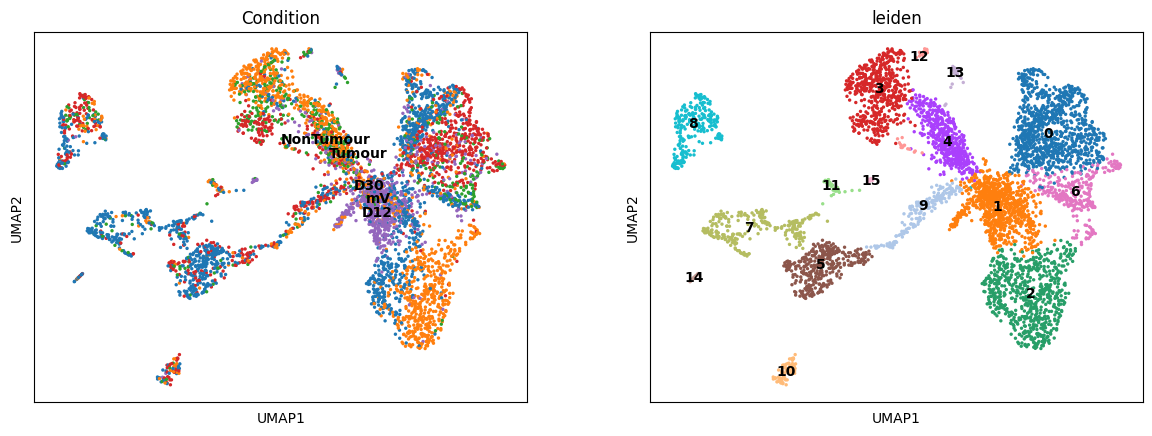

In [5]:
sc.pl.umap(adata, color = ['Condition', 'leiden'], legend_loc = 'on data')

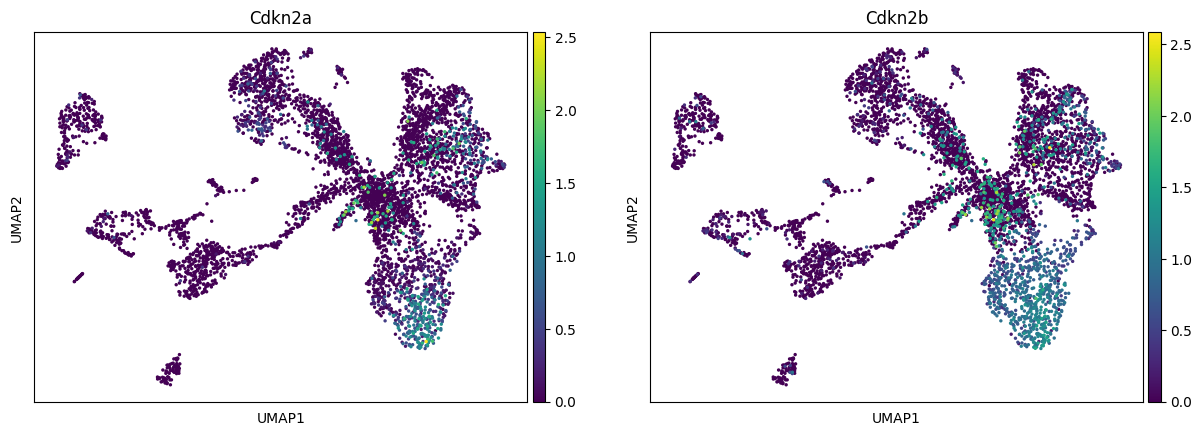

In [6]:
sc.pl.umap(adata, color = ['Cdkn2a', 'Cdkn2b'])

In [7]:
#adata.write_h5ad('../data/kras_titration/processed.h5ad')

In [69]:
adata = sc.read_h5ad('../data/kras_titration/processed.h5ad')

In [411]:
sc.set_figure_params(dpi_save = 600)

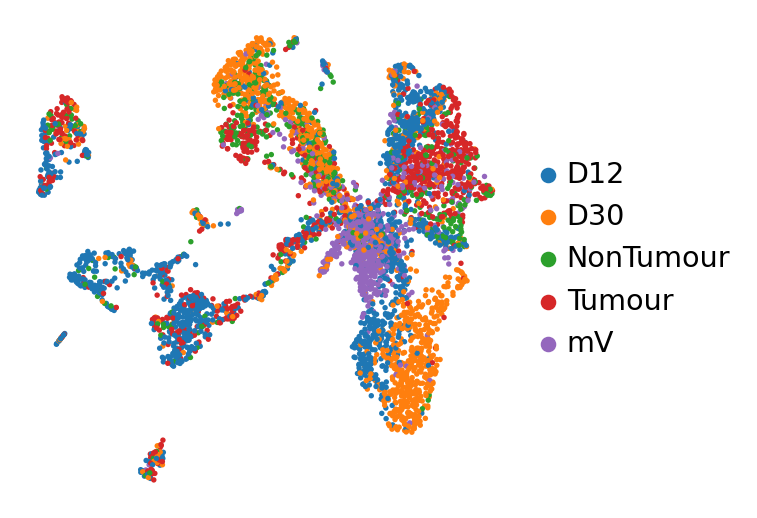

In [416]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'Condition', title = '', frameon = False, save = '_R1_PT_conditions.png')

In [70]:
pt = Pseudotime_calculator(adata=adata,
                           obsm_key="X_umap", # Dimensional reduction data name
                           cluster_column_name="leiden" # Clustering data name
                           )

In [255]:
lineage_dict = {'the_one':[x for x in adata.obs.leiden.unique() if x not in ['0', '6', '7', '8', '10', '11', '12', '13', '14', '15' ]],
               'path_0': ['1', '9', '5'],
               'path_1': ['1', '2']}

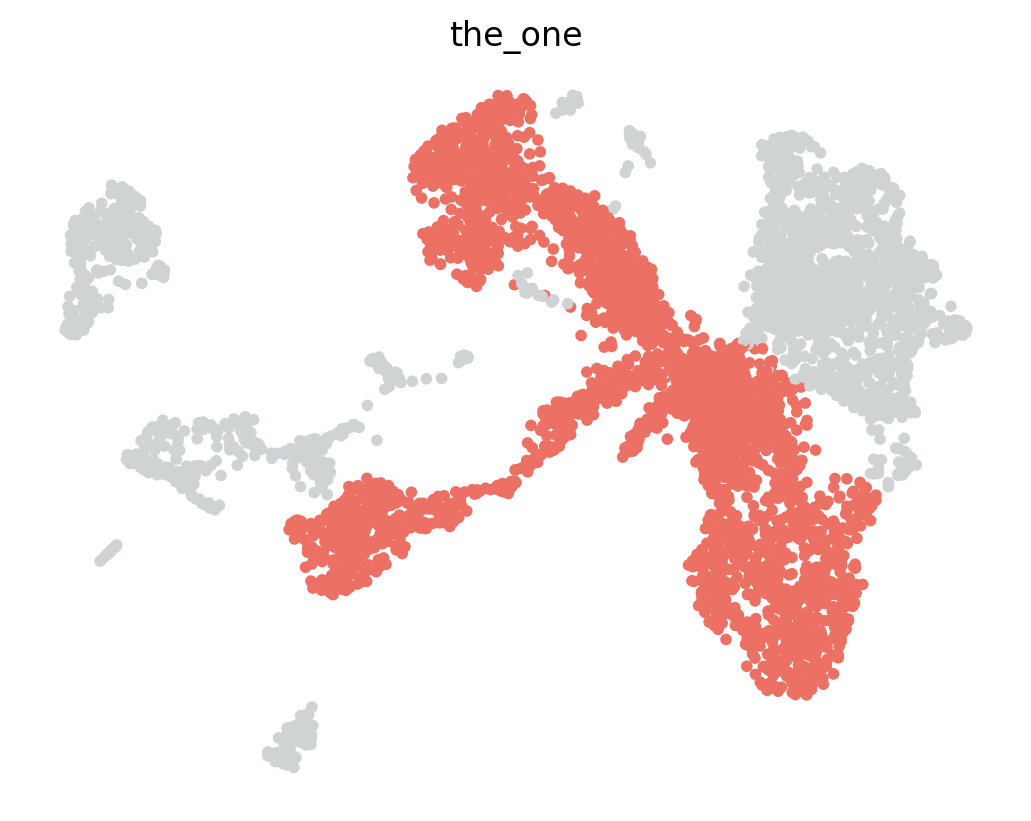

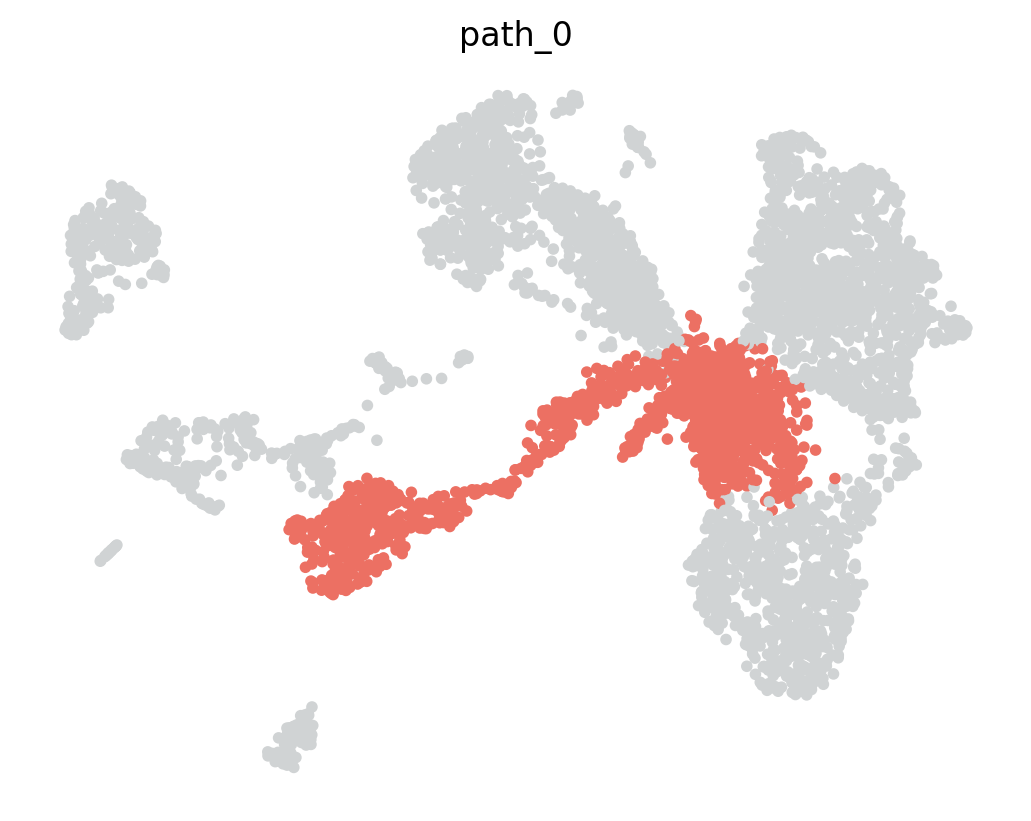

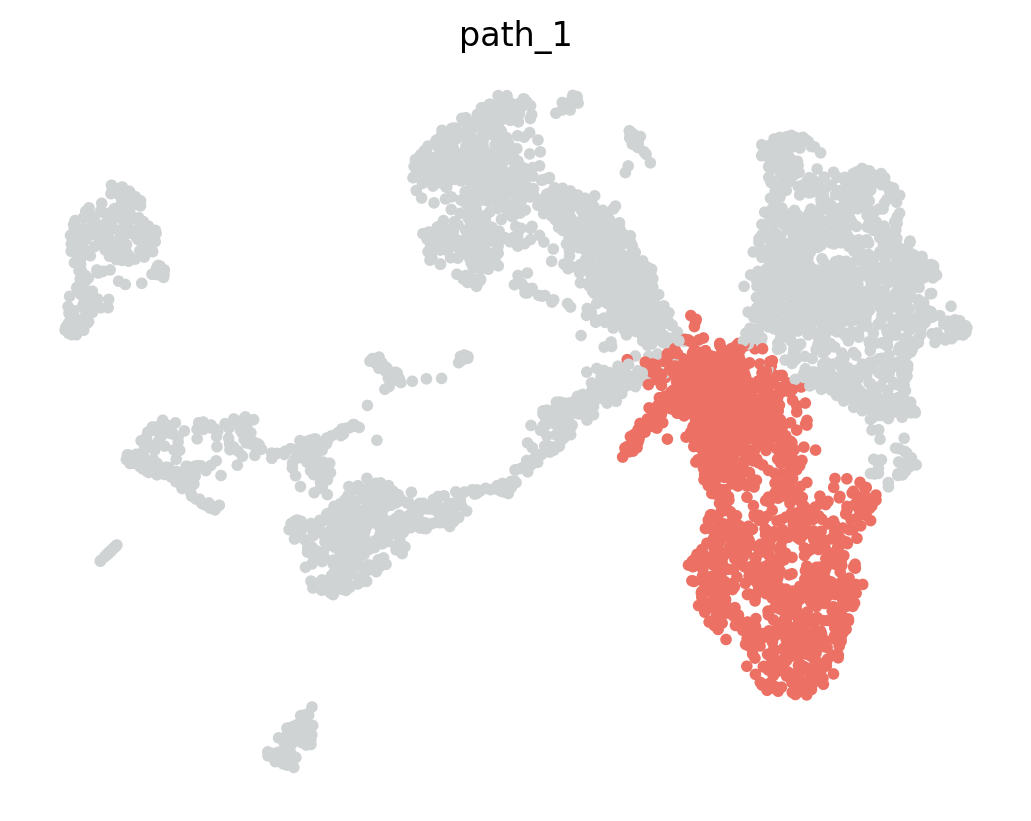

In [256]:
pt.set_lineage(lineage_dictionary=lineage_dict)
pt.plot_lineages()

In [83]:
temp = adata[adata.obs.Condition == 'mV'].copy()
temp.obs['x'] = temp.obsm['X_umap'][:,0]
temp.obs['y'] = temp.obsm['X_umap'][:,1]

In [84]:
temp = temp[(temp.obs.x < 11.25) & (temp.obs.x > 10.75)]

In [85]:
temp = temp[(temp.obs.y < 7.2) & (temp.obs.y > 6.6)]

In [86]:
temp.obs.sort_values('n_genes_by_counts')

Sample  n_genes_by_counts  log1p_n_genes_by_counts  \
GAAGCCCCAGTGTACT-1_1   mV_B                293                 5.683580   
TGTTCTATCTTCCCGA-1_1   mV_A                315                 5.755742   
CACAGATCATCCTCAC-1_0   mV_B                338                 5.826000   
CCGTGAGAGATGCTGG-1_1   mV_A                355                 5.874931   
GTGGAGAAGCACAAAT-1_0   mV_B                366                 5.905362   
AATTTCCCATGTACGT-1_1   mV_B                367                 5.908083   
GTAACACAGCGGGTTA-1_1   mV_A                381                 5.945421   
ATGTCTTAGGAAAGAC-1_1   mV_A                386                 5.958425   
ACCACAACATCTCGTC-1_1   mV_A                462                 6.137727   
TAGGTTGTCCCAAGTA-1_0   mV_B                467                 6.148468   
AGATGCTTCCCTCGAT-1_0   mV_B                512                 6.240276   
TCGCTCAGTGAGATCG-1_1   mV_B                583                 6.369901   
GTCACGGGTCTTACTT-1_1   mV_B                635                 6.455199   

                      total_counts  log1p_total_counts  \
GAAGCCCCAGTGTACT-1_1         500.0            6.216606   
TGTTCTATCTTCCCGA-1_1         587.0            6.376727   
CACAGATCATCCTCAC-1_0         609.0            6.413459   
CCGTGAGAGATGCTGG-1_1         571.0            6.349139   
GTGGAGAAGCACAAAT-1_0         693.0            6.542472   
AATTTCCCATGTACGT-1_1         595.0            6.390241   
GTAACACAGCGGGTTA-1_1         571.0            6.349139   
ATGTCTTAGGAAAGAC-1_1         677.0            6.519147   
ACCACAACATCTCGTC-1_1         843.0            6.738153   
TAGGTTGTCCCAAGTA-1_0         919.0            6.824374   
AGATGCTTCCCTCGAT-1_0         991.0            6.899723   
TCGCTCAGTGAGATCG-1_1        1383.0            7.232733   
GTCACGGGTCTTACTT-1_1        1777.0            7.483244   

                      pct_counts_in_top_20_genes  total_counts_mt  \
GAAGCCCCAGTGTACT-1_1                   38.400000              9.0   
TGTTCTATCTTCCCGA-1_1                   37.819421             30.0   
CACAGATCATCCTCAC-1_0                   38.095238              8.0   
CCGTGAGAGATGCTGG-1_1                   24.518389              6.0   
GTGGAGAAGCACAAAT-1_0                   35.497835              9.0   
AATTTCCCATGTACGT-1_1                   30.252101             19.0   
GTAACACAGCGGGTTA-1_1                   22.066550             18.0   
ATGTCTTAGGAAAGAC-1_1                   28.803545             63.0   
ACCACAACATCTCGTC-1_1                   29.893238             49.0   
TAGGTTGTCCCAAGTA-1_0                   37.323177             18.0   
AGATGCTTCCCTCGAT-1_0                   31.786075              6.0   
TCGCTCAGTGAGATCG-1_1                   30.585683             11.0   
GTCACGGGTCTTACTT-1_1                   30.444569             71.0   

                      log1p_total_counts_mt  pct_counts_mt  n_genes  Outlier  \
GAAGCCCCAGTGTACT-1_1               2.302585       1.800000      293    False   
TGTTCTATCTTCCCGA-1_1               3.433987       5.110733      315    False   
CACAGATCATCCTCAC-1_0               2.197225       1.313629      338    False   
CCGTGAGAGATGCTGG-1_1               1.945910       1.050788      355    False   
GTGGAGAAGCACAAAT-1_0               2.302585       1.298701      366    False   
AATTTCCCATGTACGT-1_1               2.995732       3.193278      367    False   
GTAACACAGCGGGTTA-1_1               2.944439       3.152364      381    False   
ATGTCTTAGGAAAGAC-1_1               4.158883       9.305761      386    False   
ACCACAACATCTCGTC-1_1               3.912023       5.812574      462    False   
TAGGTTGTCCCAAGTA-1_0               2.944439       1.958651      467    False   
AGATGCTTCCCTCGAT-1_0               1.945910       0.605449      512    False   
TCGCTCAGTGAGATCG-1_1               2.484907       0.795372      583    False   
GTCACGGGTCTTACTT-1_1               4.276666       3.995498      635    False   

                      doublet_score  predicted_doublet   Lib Conditio

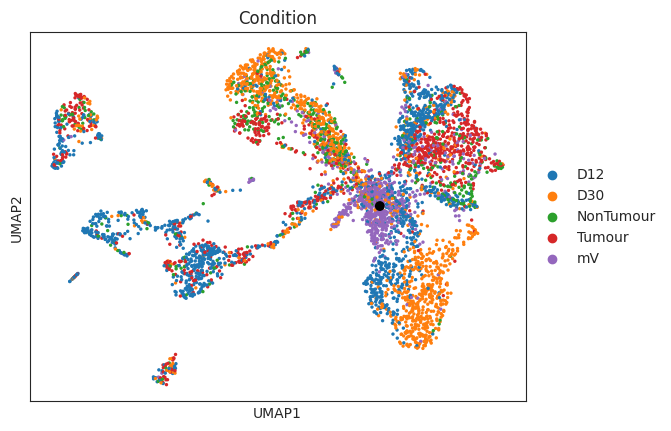

In [87]:
ax = sc.pl.umap(adata, color = ['Condition'], show = False)
sc.pl.umap(temp[temp.obs.index == 'ACCACAACATCTCGTC-1_1'], color = 'Condition', ax = ax, legend_loc = None, palette = 'k', s = 200)

In [265]:
#root cell
#GGTCACGCAAATACGA-1_1 	
root_cells = {"the_one": 'ACCACAACATCTCGTC-1_1',"path_1": 'ACCACAACATCTCGTC-1_1',"path_0": 'ACCACAACATCTCGTC-1_1'}

In [266]:
pt.set_root_cells(root_cells=root_cells)

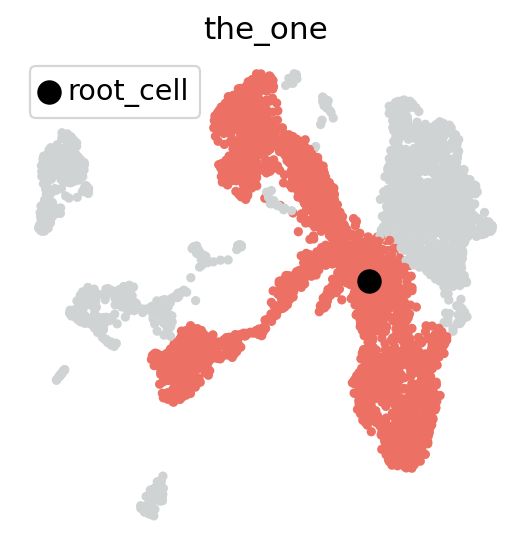

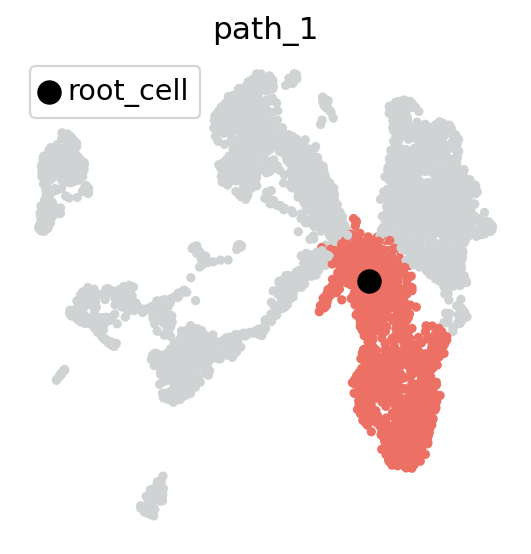

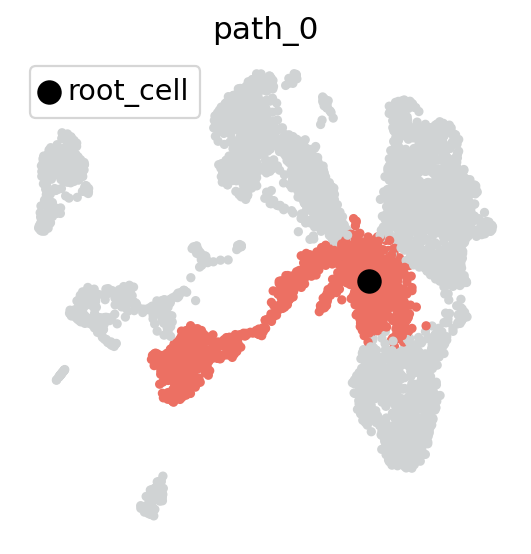

In [267]:
pt.plot_root_cells()

In [268]:
sc.tl.diffmap(pt.adata)

In [269]:
pt.get_pseudotime_per_each_lineage()

In [270]:
sc.set_figure_params(dpi_save=600, transparent=True)

In [271]:
pt.adata.obs

Sample  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCCACAAGTATCC-1_0     D30_A                772                 6.650279   
AAACCCAGTTGTCTAG-1_0     D30_A                668                 6.505784   
AAACGAACAATAAGGT-1_0     D12_A                964                 6.872128   
AAACGAAGTATGGTAA-1_0     D12_B               2725                 7.910591   
AAACGAAGTCCTCAGG-1_0  Tumour_B                506                 6.228511   
...                        ...                ...                      ...   
TTTGGTTCAATAGTCC-1_1      mV_B                607                 6.410175   
TTTGGTTCATGGAACG-1_1     D12_B               2785                 7.932362   
TTTGTTGAGAGCTGCA-1_1  Tumour_B                701                 6.553933   
TTTGTTGGTCGTGGTC-1_1     D30_B                699                 6.551080   
TTTGTTGTCCATTCGC-1_1     D30_B               1437                 7.271009   

                      total_counts  log1p_total_counts  \
AAACCCACAAGTATCC-1_0        1615.0            7.387709   
AAACCCAGTTGTCTAG-1_0        4011.0            8.297045   
AAACGAACAATAAGGT-1_0        2300.0            7.741099   
AAACGAAGTATGGTAA-1_0       12874.0            9.463042   
AAACGAAGTCCTCAGG-1_0        1011.0            6.919684   
...                            ...                 ...   
TTTGGTTCAATAGTCC-1_1        1150.0            7.048387   
TTTGGTTCATGGAACG-1_1        9438.0            9.152605   
TTTGTTGAGAGCTGCA-1_1        1634.0            7.399398   
TTTGTTGGTCGTGGTC-1_1        1405.0            7.248504   
TTTGTTGTCCATTCGC-1_1        2836.0            7.950502   

                      pct_counts_in_top_20_genes  total_counts_mt  \
AAACCCACAAGTATCC-1_0                   25.139319             18.0   
AAACCCAGTTGTCTAG-1_0                   44.178509            132.0   
AAACGAACAATAAGGT-1_0                   29.695652             75.0   
AAACGAAGTATGGTAA-1_0                   25.609756            359.0   
AAACGAAGTCCTCAGG-1_0                   34.025717              0.0   
...                                          ...              ...   
TTTGGTTCAATAGTCC-1_1                   31.913043             12.0   
TTTGGTTCATGGAACG-1_1                   19.548633            285.0   
TTTGTTGAGAGCTGCA-1_1                   28.947368              5.0   
TTTGTTGGTCGTGGTC-1_1                   25.053381              7.0   
TTTGTTGTCCATTCGC-1_1                   29.971791            203.0   

                      log1p_total_counts_mt  pct_counts_mt  n_genes  ...  \
AAACCCACAAGTATCC-1_0               2.944439       1.114551      772  ...   
AAACCCAGTTGTCTAG-1_0               4.890349       3.290950      668  ...   
AAACGAACAATAAGGT-1_0               4.330733       3.260870      964  ...   
AAACGAAGTATGGTAA-1_0               5.886104       2.788566     2725  ...   
AAACGAAGTCCTCAGG-1_0               0.000000       0.000000      506  ...   
...                                     ...            ...      ...  ...   
TTTGGTTCAATAGTCC-1_1               2.564949       1.043478      607  ...   
TTTGGTTCATGGAACG-1_1               5.655992       3.019708     2785  ...   
TTTGTTGAGAGCTGCA-1_1               1.791759       0.305998      701  ...   
TTTGTTGGTCGTGGTC-1_1               2.079442       0.498221      699  ...   
TTTGTTGTCCATTCGC-1_1               5.318120       7.157969     1437  ...   

                       Lib  Condition  leiden the_one Pseudotime_the_one  \
AAACCCACAAGTATCC-1_0  Lib1        D30       9    True           0.516399   
AAACCCAGTTGTCTAG-1_0  Lib1        D30       6   False                NaN   
AAACGAACAATAAGGT-1_0  Lib1        D12       7   False                NaN   
AAACGAAGTATGGTAA-1_0  Lib1        D12       7   False                NaN   
AAACGAAGTCCTCAGG-1_0  Lib1     Tumour       0   False                NaN   
...                    ...        ...     ...     ...                ...   
TTTGGTTCAATAGTCC-1_1  Lib2         mV       1    True           0.028923   
TTTGGTTCATGGAACG-1_1  Lib2        D12   

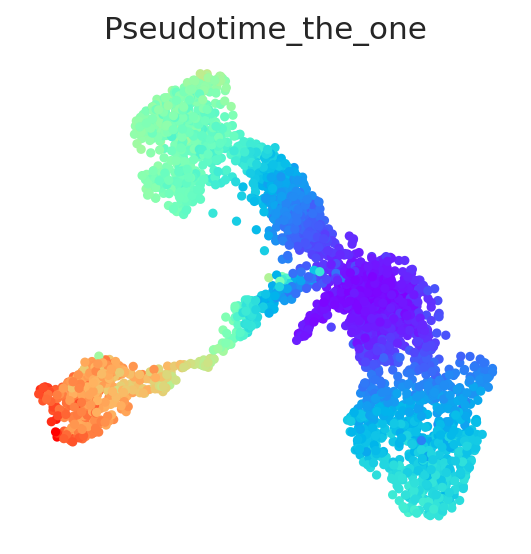

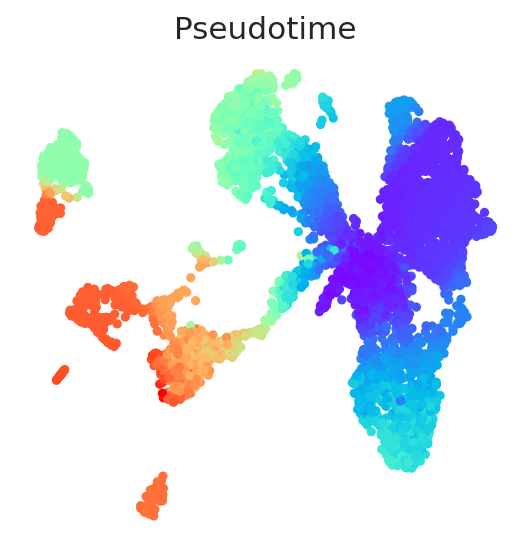

In [171]:
pt.plot_pseudotime(cmap="rainbow")

In [128]:
pt.adata.obs

Sample  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCCACAAGTATCC-1_0     D30_A                772                 6.650279   
AAACCCAGTTGTCTAG-1_0     D30_A                668                 6.505784   
AAACGAACAATAAGGT-1_0     D12_A                964                 6.872128   
AAACGAAGTATGGTAA-1_0     D12_B               2725                 7.910591   
AAACGAAGTCCTCAGG-1_0  Tumour_B                506                 6.228511   
...                        ...                ...                      ...   
TTTGGTTCAATAGTCC-1_1      mV_B                607                 6.410175   
TTTGGTTCATGGAACG-1_1     D12_B               2785                 7.932362   
TTTGTTGAGAGCTGCA-1_1  Tumour_B                701                 6.553933   
TTTGTTGGTCGTGGTC-1_1     D30_B                699                 6.551080   
TTTGTTGTCCATTCGC-1_1     D30_B               1437                 7.271009   

                      total_counts  log1p_total_counts  \
AAACCCACAAGTATCC-1_0        1615.0            7.387709   
AAACCCAGTTGTCTAG-1_0        4011.0            8.297045   
AAACGAACAATAAGGT-1_0        2300.0            7.741099   
AAACGAAGTATGGTAA-1_0       12874.0            9.463042   
AAACGAAGTCCTCAGG-1_0        1011.0            6.919684   
...                            ...                 ...   
TTTGGTTCAATAGTCC-1_1        1150.0            7.048387   
TTTGGTTCATGGAACG-1_1        9438.0            9.152605   
TTTGTTGAGAGCTGCA-1_1        1634.0            7.399398   
TTTGTTGGTCGTGGTC-1_1        1405.0            7.248504   
TTTGTTGTCCATTCGC-1_1        2836.0            7.950502   

                      pct_counts_in_top_20_genes  total_counts_mt  \
AAACCCACAAGTATCC-1_0                   25.139319             18.0   
AAACCCAGTTGTCTAG-1_0                   44.178509            132.0   
AAACGAACAATAAGGT-1_0                   29.695652             75.0   
AAACGAAGTATGGTAA-1_0                   25.609756            359.0   
AAACGAAGTCCTCAGG-1_0                   34.025717              0.0   
...                                          ...              ...   
TTTGGTTCAATAGTCC-1_1                   31.913043             12.0   
TTTGGTTCATGGAACG-1_1                   19.548633            285.0   
TTTGTTGAGAGCTGCA-1_1                   28.947368              5.0   
TTTGTTGGTCGTGGTC-1_1                   25.053381              7.0   
TTTGTTGTCCATTCGC-1_1                   29.971791            203.0   

                      log1p_total_counts_mt  pct_counts_mt  n_genes  Outlier  \
AAACCCACAAGTATCC-1_0               2.944439       1.114551      772    False   
AAACCCAGTTGTCTAG-1_0               4.890349       3.290950      668    False   
AAACGAACAATAAGGT-1_0               4.330733       3.260870      964    False   
AAACGAAGTATGGTAA-1_0               5.886104       2.788566     2725    False   
AAACGAAGTCCTCAGG-1_0               0.000000       0.000000      506    False   
...                                     ...            ...      ...      ...   
TTTGGTTCAATAGTCC-1_1               2.564949       1.043478      607    False   
TTTGGTTCATGGAACG-1_1               5.655992       3.019708     2785    False   
TTTGTTGAGAGCTGCA-1_1               1.791759       0.305998      701    False   
TTTGTTGGTCGTGGTC-1_1               2.079442       0.498221      699    False   
TTTGTTGTCCATTCGC-1_1               5.318120       7.157969     1437    False   

                      doublet_score  predicted_doublet   Lib Condition leiden  \
AAACCCACAAGTATCC-1_0       0.042017              False  Lib1       D30      9   
AAACCCAGTTGTCTAG-1_0       0.024421              False  Lib1       D30      6   
AAACGAACAATAAGGT-1_0       0.064877              False  Lib1       D12      7   
AAACGAAGTATGGTAA-1_0       0.054726              False  Lib1       D12      7   
AAACGAAGTCCTCAGG-1_0       0.049120              False  Lib1    Tumour      0   
...                             ...                ...   ...       ...    ...   
TTTGGTTCAATAGTCC-1_1       0.0219

In [129]:
hubs = sp.load_hubs(species = 'Mouse')

In [130]:
hubs.metadata[hubs.metadata.tissue == 'Liver']

tissue                                  cell  hub_num  size  n_sen  \
40  Liver                          Kupffer cell        0   638     14   
41  Liver                          Kupffer cell        1  3305     17   
42  Liver  endothelial cell of hepatic sinusoid        0   205     12   
43  Liver                            hepatocyte        0  1600     14   
44  Liver                            hepatocyte        1   143      7   

             hyp  
40  2.268194e-03  
41  9.983103e-01  
42  4.280991e-07  
43  6.086587e-01  
44  3.511115e-04

In [131]:
trans = sp.translator(hub = hubs.hubs, data = adata)

2910 of 19546 genes not initially present
1659 of 2910 translated
1251 still not present


In [132]:
adata.X = adata.raw.to_adata().X.copy()

In [133]:
adata.obs['Hep_1'] = sp.score_hub(adata, hubs.hubs[('Liver', 'hepatocyte', 1)],
                                          translator = trans, binarize=True, importance=True)

130/143(90.91%) genes present in data
140/143(97.9%) genes present in data after translation
Still not present: ['Gm6981', 'Clec7a', 'Gp49a']


In [134]:
adata.obs['Hep_0'] = sp.score_hub(adata, hubs.hubs[('Liver', 'hepatocyte', 0)],
                                          translator = trans, binarize=True, importance=True)

1335/1600(83.44%) genes present in data
1473/1600(92.06%) genes present in data after translation
Still not present: ['Gm4477', 'Gm8615', 'Rnls', 'AV051173', 'Npm3-ps1', 'Raet1a', 'BC090627', 'Hbb-b2', 'Olig1', 'Gm19897', 'Prok1', 'Tmprss9', 'Abhd1', 'Mirlet7b', 'Gm5077', '3200001D21Rik', 'Nup62-il4i1', '4930538K18Rik', '6330549D23Rik', 'Gm5741', 'Gm10548', 'BC096441', 'Mir207', 'Prkag3', 'Gm10416', '4930568K20Rik', 'Raver1-fdx1l', 'D830031N03Rik', '9530048J24Rik', 'Slc15a5', 'AA543186', 'AI507597', '4930512B01Rik', 'Gm10804', '1700030C10Rik', 'Mir16-1', '4931403G20Rik', 'Apba2', 'Mir3061', '1700120E14Rik', '4930524O05Rik', 'LOC622167', 'B4galnt3', 'Tpte', 'Mir5133', 'Olfr701', 'Adat3', 'Slc25a18', 'Zfp534', 'Slc38a5', 'Uty', 'Mir1931', '4930473A02Rik', 'Tbrg3', 'Gm18756', 'LOC380994', 'Pcdh20', 'Slc26a4', 'Zfp862', 'B130006D01Rik', '4930413G21Rik', 'Gm20604', 'Olfr1030', 'Gm5801', 'Gm5887', 'C130039O16Rik', 'Fbxo40', 'Prss48', 'Rgr', 'Mir568', 'Ctcfl', 'A930013F10Rik', 'Snhg7', 'A2300

In [135]:
lit_markers = [(x, 1) for x in list(hubs.literature_markers)]

In [136]:
adata.obs['lit_sen_score'] = sp.score_hub(adata, lit_markers, translator = trans, importance=False, binarize=False)

165/184(89.67%) genes present in data
165/184(89.67%) genes present in data after translation
Still not present: ['Cxcl11', 'Ccl11', 'Mmp3', 'Mmp10', 'Mmp16', 'Mmp21', 'Ccl13', 'Ccl16', 'Ccl26', 'Ccl3l1', 'Cst4', 'Cxcl8', 'Dkk1', 'Icam3', 'Il32', 'Kitlg', 'Mmp1', 'Serpinb4', 'Tnfrsf10c']


In [140]:
hubs.merge_hubs(hubs.metadata, new_name = 'universal', calculate_thresh = True, p_thres = 0.01)

A gene will occur 4 times at 0.72% chance
Threfore 4 is the calculated_threshold


Gene  Count   p value   q value
0            Hba-a1     27  0.000000  0.000000
1            Hbb-b1     20  0.000000  0.000000
2           Gm11428     19  0.000000  0.000000
3             Vsig4     18  0.000000  0.000000
4              Saa3     18  0.000000  0.000000
...             ...    ...       ...       ...
1135  B430306N03Rik      4  0.000851  0.007168
1136         Entpd4      4  0.000851  0.007168
1137          Ptgis      4  0.000851  0.007168
1138         Slc2a9      4  0.000851  0.007168
1139         Asprv1      4  0.000851  0.007168

[1140 rows x 4 columns]

In [143]:
adata.obs['Universal'] = sp.score_hub(adata, hubs.hubs['universal'],
                                          translator = trans, binarize=True, importance=True)

985/1140(86.4%) genes present in data
1065/1140(93.42%) genes present in data after translation
Still not present: ['Slc38a5', 'Tac1', '4931408D14Rik', 'Ccl11', 'H2-Q8', 'Clec7a', 'Gm7609', 'Atp6v0c-ps2', 'Fcnb', 'Gp49a', 'Olfr613', 'Ms4a3', 'Gm12250', 'Gm8580', 'Kcne4', 'Retnla', 'H2-T10', 'Gm12504', 'Hbb-b1', 'Hbb-b2', 'BC064078', 'Gm5069', 'Entpd4', 'Gm10653', 'Gdap10', 'Vmn2r-ps129', 'Gp1bb', 'Gypa', '1700086L19Rik', 'Krtdap', 'Gm13315', 'Fam151a', 'Krt13', 'Them5', 'Slc4a1', 'D14Ertd449e', 'Calml3', 'Bpifa1', 'Krt84', 'Mpo', 'Krt36', 'Car4', 'Aqp2', 'Npm3-ps1', 'Mx2', '4930413G21Rik', 'Gm16907', 'Ngp', 'Mmp3', 'Rps19-ps3', 'Gm10804', 'D730005E14Rik', 'Abhd1', 'Oas1b', 'Slc6a18', 'A930013F10Rik', 'LOC545261', 'Gm14005', 'Zxda', 'Beta-s', 'Aldh3b2', 'Gm5803', 'Slfn10-ps', 'Dnase1', 'Rnls', 'Trim29', 'Gm10548', 'Krt35', 'Prss34', 'Krt6b', 'Calm4', 'Tymp', 'Nppa', 'Ccdc153', 'Sec14l3']


In [474]:
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist()
senmayo = [x[0] + x[1:].lower() for x in senmayo]

In [477]:
adata.obs['senMayo'] = sp.score_hub(adata, [(x,1) for x in senmayo],
                                    translator = trans, importance=False, binarize=False)

110/125(88.0%) genes present in data
110/125(88.0%) genes present in data after translation
Still not present: ['Ccl13', 'Ccl16', 'Ccl26', 'Ccl3l1', 'Cst4', 'Cxcl8', 'Dkk1', 'Icam3', 'Il32', 'Kitlg', 'Mmp1', 'Mmp10', 'Mmp3', 'Serpinb4', 'Tnfrsf10c']


In [ ]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(pt.adata, color = 'Pseudotime', cmap = "rainbow", frameon = False, s = 50)

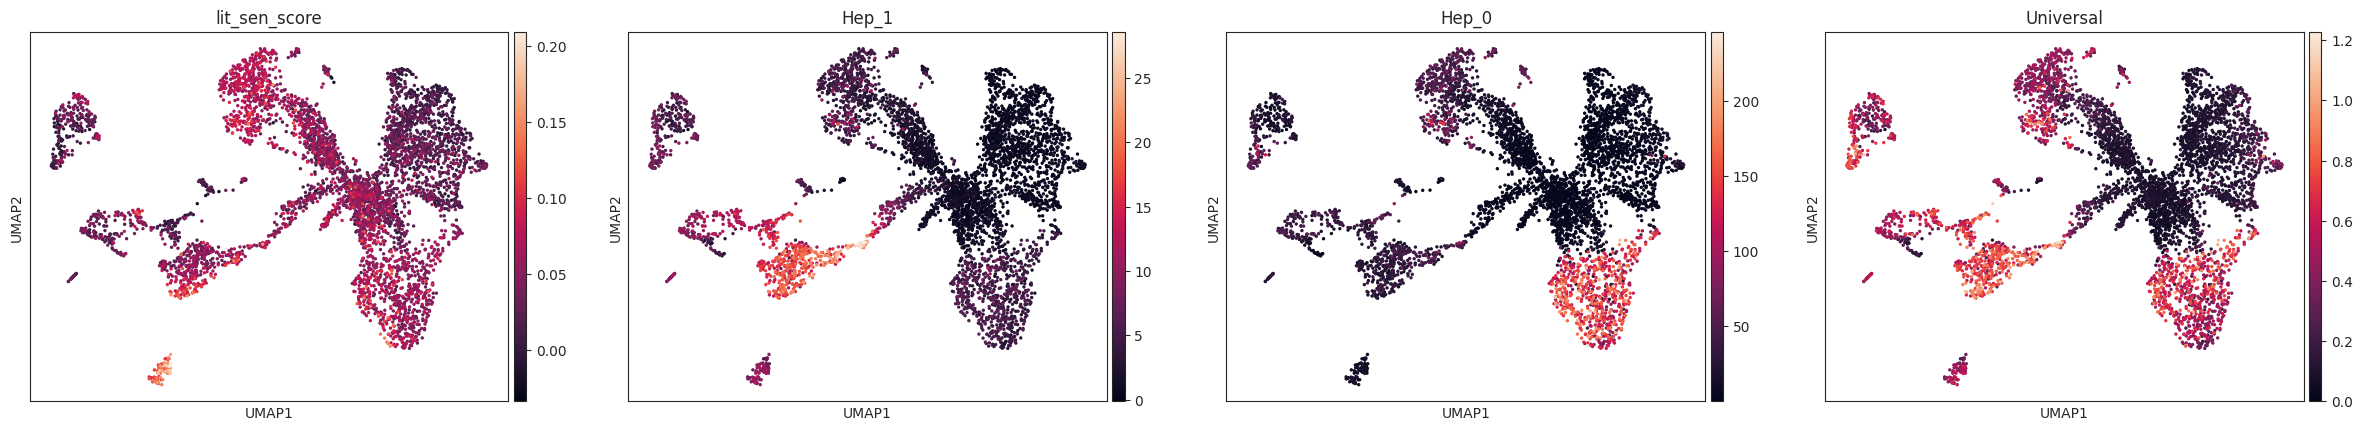

In [149]:
sc.pl.umap(adata, color = ['lit_sen_score', 'Hep_1', 'Hep_0', 'Universal'])

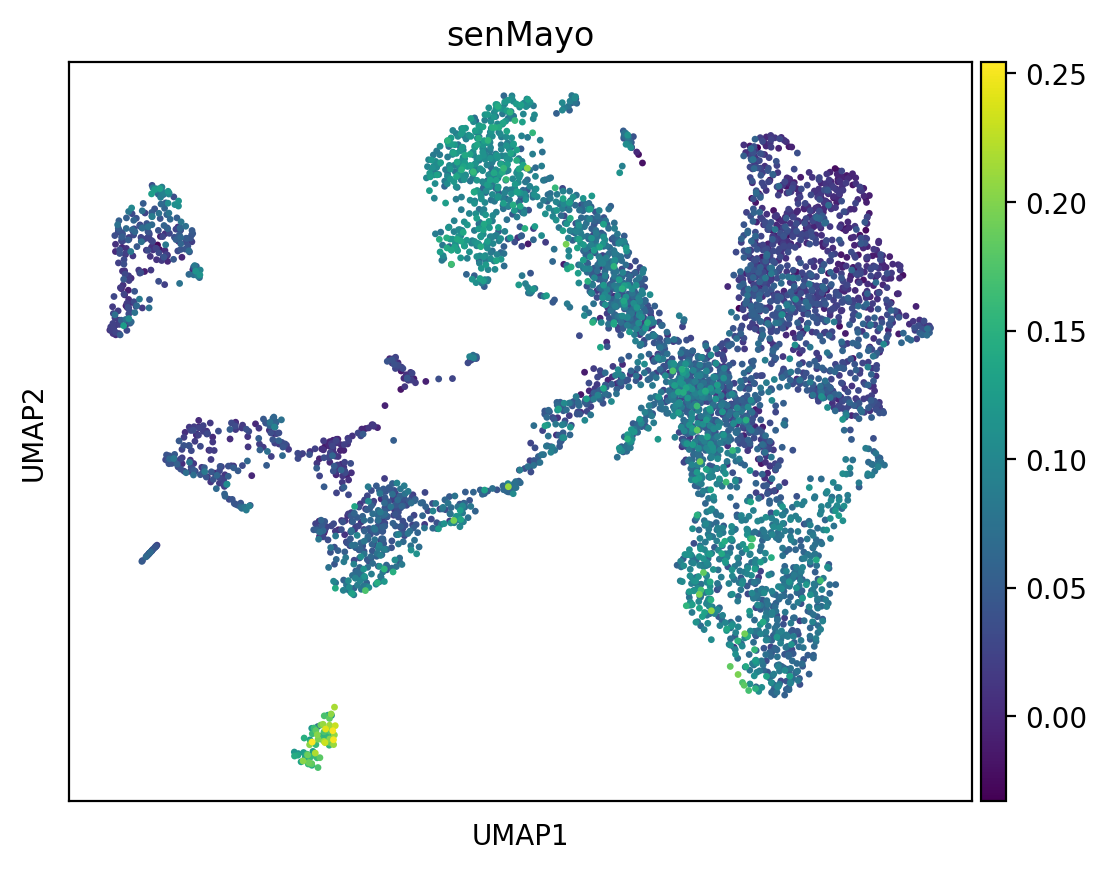

In [478]:
sc.pl.umap(adata, color = ['senMayo'])

In [173]:
sc.set_figure_params(dpi_save=600, transparent=True)

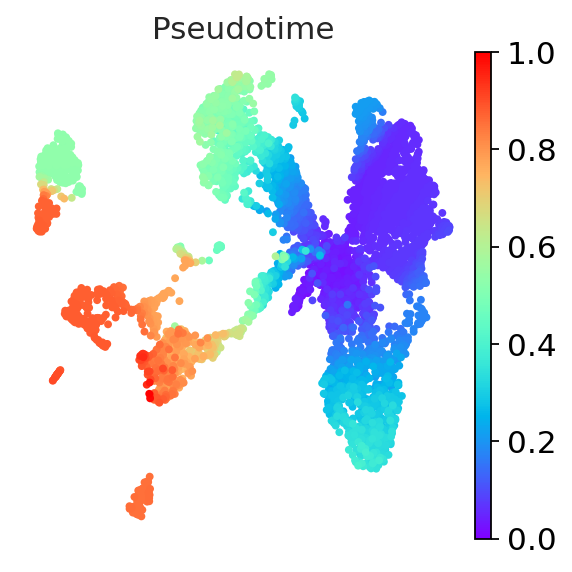

In [175]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(pt.adata, color = 'Pseudotime', cmap = "rainbow", frameon = False, s = 50,
               save = '_R1_PT_pseudotime.svg')

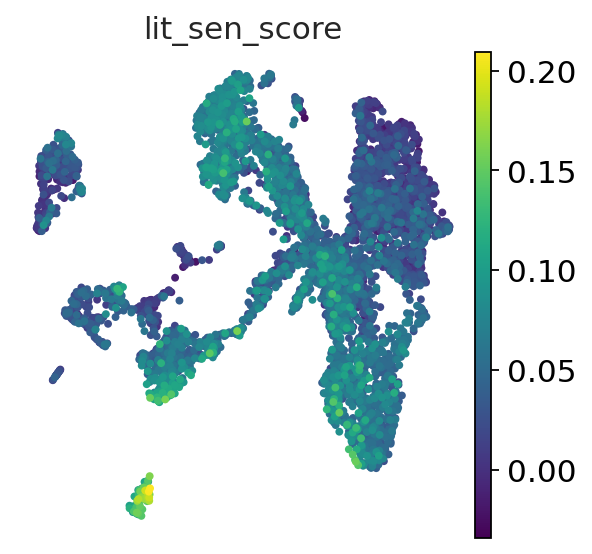

In [184]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'lit_sen_score', frameon = False, s = 50, cmap = 'viridis',
               save = '_R1_PT_lit_score.svg'
              )

In [179]:
stats.pearsonr(pt.adata.obs.Pseudotime, adata.obs.lit_sen_score)

PearsonRResult(statistic=0.28476085532836776, pvalue=6.299536997798726e-94)

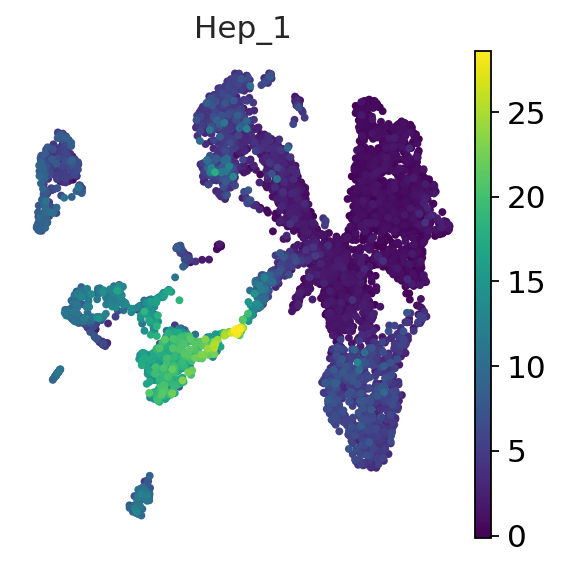

In [188]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'Hep_1', frameon = False, s = 50, cmap = 'viridis',
               save = '_R1_PT_Hep_1_score.png'
              )

In [186]:
stats.pearsonr(pt.adata.obs.Pseudotime, adata.obs.Hep_1)

PearsonRResult(statistic=0.8019847868201367, pvalue=0.0)

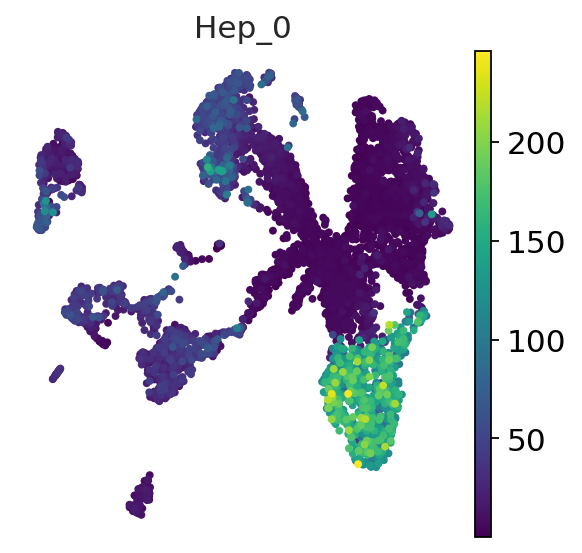

In [191]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'Hep_0', frameon = False, s = 50, cmap = 'viridis',
               save = '_R1_PT_Hep_0_score.svg'
              )

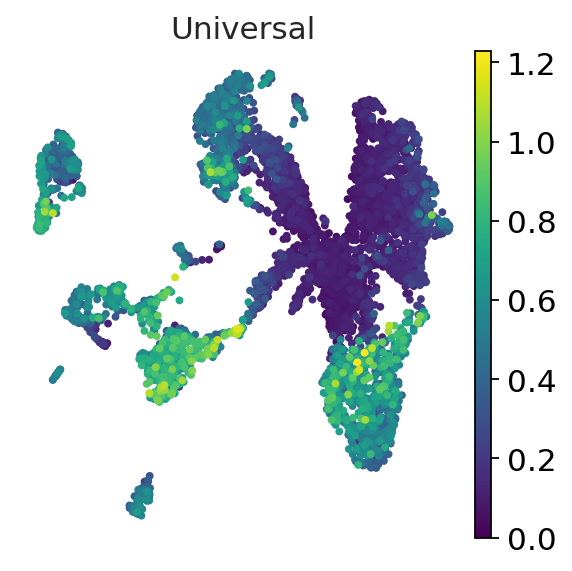

In [194]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'Universal', frameon = False, s = 50, cmap = 'viridis',
               save = '_R1_PT_Universal_score.svg'
              )

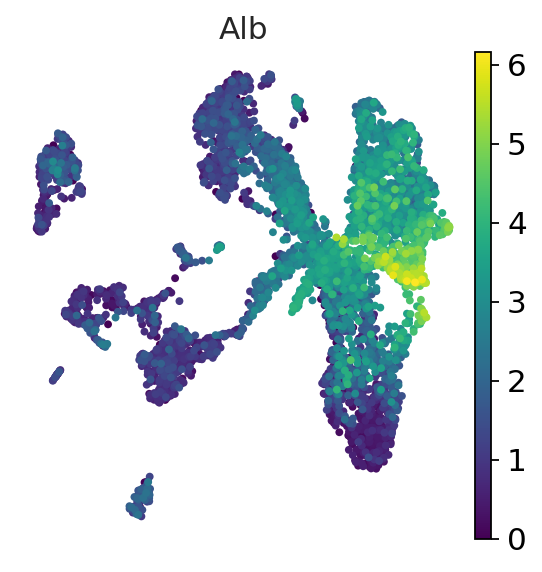

In [205]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'Alb', frameon = False, s = 50, cmap = 'viridis',
               save = '_R1_PT_ALB.png'
              )

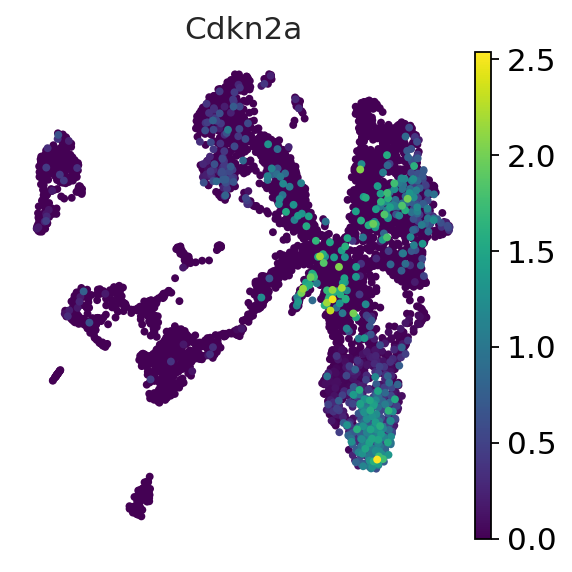

In [208]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'Cdkn2a', frameon = False, s = 50, cmap = 'viridis',
               save = '_R1_PT_Cdkn2a.svg'
              )

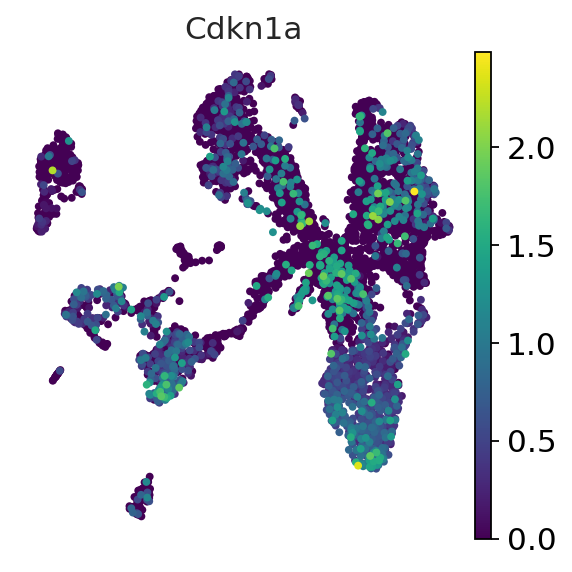

In [210]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'Cdkn1a', frameon = False, s = 50, cmap = 'viridis',
               save = '_R1_PT_Cdkn1a.svg'
              )

In [479]:
sc.set_figure_params(dpi_save = 600)

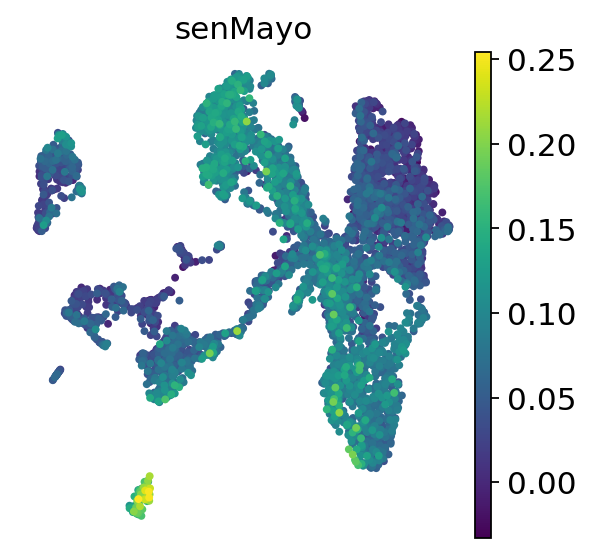

In [480]:
with rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color = 'senMayo', frameon = False, s = 50, cmap = 'viridis',
               save = '_R1_PT_senMayo.svg'
              )

In [195]:
adata.obs['Pseudotime'] = pt.adata.obs.Pseudotime.copy()

In [459]:
grapher = adata.obs.melt(value_vars = ['lit_sen_score', 'Universal'], id_vars = 'Pseudotime')

In [460]:
grapher['Score'] = grapher.groupby('variable')['value'].transform(lambda x: x / x.max())#norm each to 

In [461]:
grapher = grapher.replace({'lit_sen_score':'senMarkers', 'Universal':'senePy'})

In [462]:
grapher

Pseudotime    variable     value     Score
0        0.516399  senMarkers  0.070665  0.337358
1        0.090247  senMarkers  0.012593  0.060117
2        0.855687  senMarkers  0.064078  0.305914
3        0.875832  senMarkers  0.031162  0.148770
4        0.051987  senMarkers  0.021074  0.100608
...           ...         ...       ...       ...
9997     0.028923      senePy  0.102394  0.083404
9998     0.768523      senePy  0.609348  0.496335
9999     0.062359      senePy  0.157518  0.128304
10000    0.210423      senePy  0.093469  0.076134
10001    0.537098      senePy  0.258840  0.210834

[10002 rows x 4 columns]

In [443]:
a = grapher[grapher.variable == 'senMarkers'].copy()
b = grapher[grapher.variable == 'senePy'].copy()

In [448]:
plt.rcdefaults()

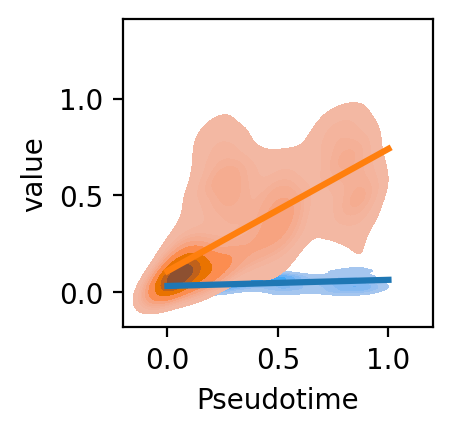

In [453]:
plt.figure(figsize = (2,2))

ax = sns.kdeplot(data=a, x="Pseudotime", y="value", fill=True)
ax = sns.kdeplot(data=b, x="Pseudotime", y="value", fill=True)
ax = sns.regplot(data = a, x = 'Pseudotime', y = 'value', scatter=False)
ax = sns.regplot(data = b, x = 'Pseudotime', y = 'value', scatter=False)

plt.savefig('figures/R1_PT_universal.svg', bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_PT_universal.png', dpi = 600, bbox_inches = 'tight', transparent = True)

plt.show()

In [487]:
grapher = adata.obs.melt(value_vars = ['senMayo', 'Universal'], id_vars = 'Pseudotime')
grapher['Score'] = grapher.groupby('variable')['value'].transform(lambda x: x / x.max())#norm each to 
grapher = grapher.replace({'lit_sen_score':'senMarkers', 'Universal':'senePy'})
a = grapher[grapher.variable == 'senMayo'].copy()
b = grapher[grapher.variable == 'senePy'].copy()

In [489]:
plt.rcdefaults()

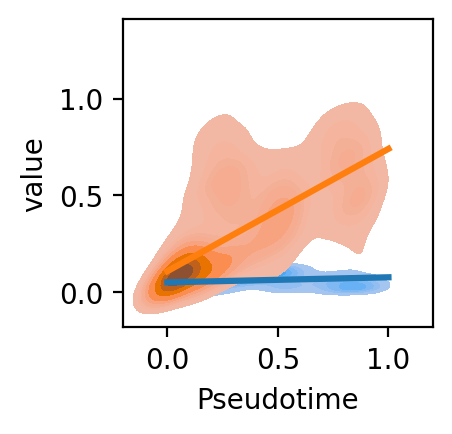

In [490]:
plt.figure(figsize = (2,2))

ax = sns.kdeplot(data=a, x="Pseudotime", y="value", fill=True)
ax = sns.kdeplot(data=b, x="Pseudotime", y="value", fill=True)
ax = sns.regplot(data = a, x = 'Pseudotime', y = 'value', scatter=False)
ax = sns.regplot(data = b, x = 'Pseudotime', y = 'value', scatter=False)

plt.savefig('figures/R1_PT_mayo_vs_py.svg', bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_PT_mayo_vs_pyl.png', dpi = 600, bbox_inches = 'tight', transparent = True)

plt.show()

In [508]:
stats.pearsonr(adata.obs.Pseudotime, adata.obs.Universal)

PearsonRResult(statistic=0.696890008779556, pvalue=0.0)

In [250]:
plt.rcdefaults()

In [272]:
adata.obs['path_0'] = pt.adata.obs.Pseudotime_path_0
adata.obs['path_1'] = pt.adata.obs.Pseudotime_path_1

In [298]:
i = np.where(adata.var_names == 'Alb')[0][0]

adata.obs['Alb_exp'] = adata.X[:,i].toarray().flatten()

In [300]:
stats.pearsonr(adata.obs.Universal, adata.obs.Alb_exp) #inversly correlated to alb expression

PearsonRResult(statistic=-0.5326088336910314, pvalue=0.0)

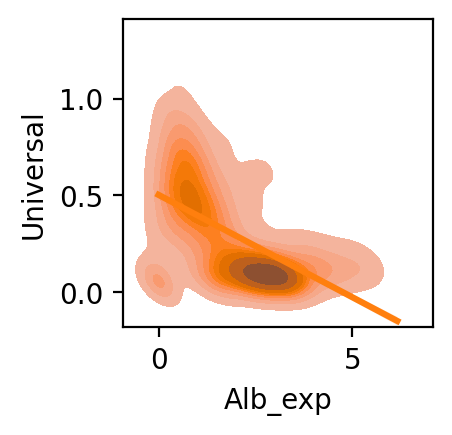

In [470]:
plt.figure(figsize = (2,2))

ax = sns.kdeplot(data=adata.obs, x="Alb_exp", y="Universal", fill=True, color = 'tab:orange')
ax = sns.regplot(data = adata.obs, x = 'Alb_exp', y = 'Universal', scatter=False, color = 'tab:orange')

plt.savefig('figures/R1_PT_sen_v_alb.svg', bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_PT_sen_v_alb.png', dpi = 600, bbox_inches = 'tight', transparent = True)

plt.show()

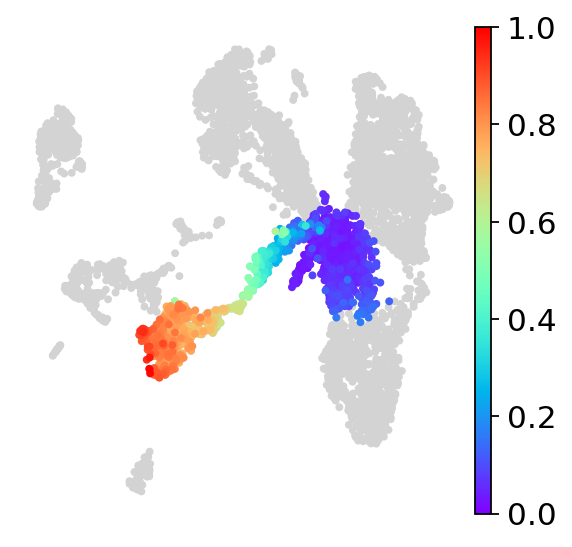

In [305]:
with rc_context({"figure.figsize": (4, 4)}):

    ax = sc.pl.umap(adata, show = False, s = 50, frameon=False, title = '')
    sc.pl.umap(adata[~adata.obs.path_0.isna()], ax = ax, color = 'path_0',
               cmap = 'rainbow', s = 50, title = '',
              save = '_R1_PT_path_0.png'
              )

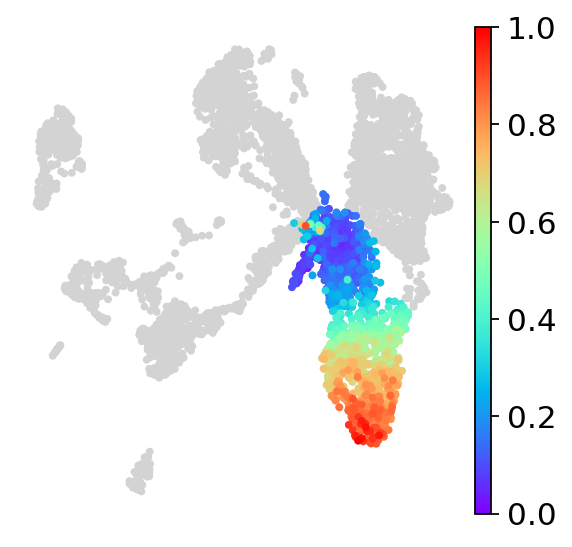

In [307]:
with rc_context({"figure.figsize": (4, 4)}):

    ax = sc.pl.umap(adata, show = False, s = 50, frameon=False, title = '')
    sc.pl.umap(adata[~adata.obs.path_1.isna()], ax = ax, color = 'path_1',
               cmap = 'rainbow', s = 50, title = '',
              save = '_R1_PT_path_1.svg'
              )

In [506]:
_ = adata.obs[~adata.obs.path_0.isna()]


stats.pearsonr(_.Hep_0, _.path_0)

PearsonRResult(statistic=0.730774782631032, pvalue=2.0224612812814145e-232)

In [507]:
_ = adata.obs[~adata.obs.path_1.isna()]


stats.pearsonr(_.Hep_1, _.path_1)

PearsonRResult(statistic=0.7920692467428263, pvalue=0.0)

In [310]:
plt.rcdefaults()

In [357]:
grapher = adata.obs.copy()

#D12 and D30 also very sig higher than non-tumor/tumor but keeping story simpler:
grapher = adata.obs[adata.obs.Condition.isin(['D12', 'D30', 'mV'])]

grapher['Condition'] = pd.Categorical(grapher['Condition'],
                                             categories=['mV', 'D12', 'D30'], ordered=True)

#grapher.Condition = grapher.Condition.astype(str)

grapher = grapher.sort_values('Condition', key=lambda x: x.cat.codes)

#grapher = grapher.sort_values('Condition', ascending = False)

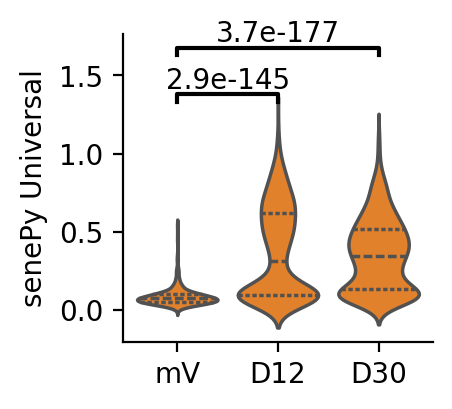

In [398]:
plt.figure(figsize = (2,2))

ax = sns.violinplot(data = grapher, x = 'Condition', y = 'Universal',
                    density_norm = 'width', inner="quart", color = 'tab:orange')



# Setting the y position for the bars
y = grapher['Universal'].max() + 0.1
h = 0.05  # height for the bars
col = 'k'  # color of the bars

# Adding the significance bar from mV (index 0) to the second condition (index 1)
p = stats.mannwhitneyu(adata.obs[adata.obs.Condition == 'D12'].Universal,
                   adata.obs[adata.obs.Condition == 'mV'].Universal, alternative = 'greater').pvalue
p = f"{p:.1e}"
x1, x2 = 0, 1
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color=col)
plt.text((x1 + x2) * 0.5, y + h, p, ha='center', va='bottom', color=col)



# Adding the significance bar from mV (index 0) to the second condition (index 1)
p = stats.mannwhitneyu(adata.obs[adata.obs.Condition == 'D30'].Universal,
                   adata.obs[adata.obs.Condition == 'mV'].Universal, alternative = 'greater').pvalue
p = f"{p:.1e}"
x1, x2 = 0, 2
plt.plot([x1, x1, x2, x2], [y + 6 * h, y + 7 * h, y + 7 * h, y + 6 * h], lw=1.5, color=col)
plt.text((x1 + x2) * 0.5, y + 7 * h, p, ha='center', va='bottom', color=col)


plt.xlabel('')
plt.ylabel('senePy Universal')

sns.despine(top=True, right=True)

plt.savefig('figures/R1_PT_sp_v_marks1.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_PT_sp_v_marks1.svg', bbox_inches = 'tight', transparent = True)


plt.show()

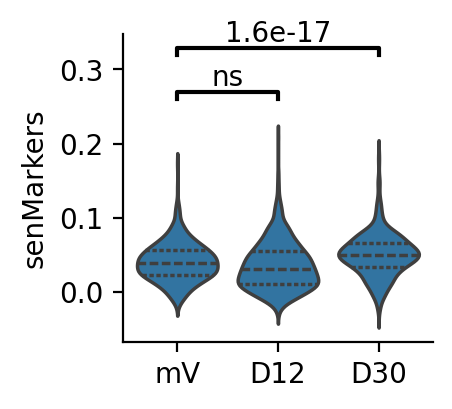

In [406]:
plt.figure(figsize = (2,2))

ax = sns.violinplot(data = grapher, x = 'Condition', y = 'lit_sen_score',
                    density_norm = 'width', inner="quart", color = 'tab:blue')



# Setting the y position for the bars
y = grapher['lit_sen_score'].max() + 0.05
h = 0.01  # height for the bars
col = 'k'  # color of the bars


# Adding the significance bar from mV (index 0) to the second condition (index 1)
p = stats.mannwhitneyu(adata.obs[adata.obs.Condition == 'D12'].lit_sen_score,
                   adata.obs[adata.obs.Condition == 'mV'].lit_sen_score, alternative = 'greater').pvalue
p = f"{p:.1e}"
x1, x2 = 0, 1
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color=col)
plt.text((x1 + x2) * 0.5, y + h, 'ns', ha='center', va='bottom', color=col)


# Adding the significance bar from mV (index 0) to the second condition (index 1)
p = stats.mannwhitneyu(adata.obs[adata.obs.Condition == 'D30'].lit_sen_score,
                   adata.obs[adata.obs.Condition == 'mV'].lit_sen_score, alternative = 'greater').pvalue
p = f"{p:.1e}"
x1, x2 = 0, 2
plt.plot([x1, x1, x2, x2], [y + 6 * h, y + 7 * h, y + 7 * h, y + 6 * h], lw=1.5, color=col)
plt.text((x1 + x2) * 0.5, y + 7 * h, p, ha='center', va='bottom', color=col)

sns.despine(top=True, right=True)

plt.xlabel('')
plt.ylabel('senMarkers')

plt.savefig('figures/R1_PT_sp_v_marks2.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_PT_sp_v_marks2.svg', bbox_inches = 'tight', transparent = True)

plt.show()

In [367]:
stats.mannwhitneyu(adata.obs[adata.obs.Condition == 'D12'].Universal,
                   adata.obs[adata.obs.Condition == 'mV'].Universal, alternative = 'greater')

MannwhitneyuResult(statistic=955798.0, pvalue=2.8851138018895737e-145)

In [368]:
stats.mannwhitneyu(adata.obs[adata.obs.Condition == 'D30'].Universal,
                   adata.obs[adata.obs.Condition == 'mV'].Universal, alternative = 'greater')

MannwhitneyuResult(statistic=824172.5, pvalue=3.7371806843500885e-177)

In [369]:
stats.mannwhitneyu(adata.obs[adata.obs.Condition == 'D12'].lit_sen_score,
                   adata.obs[adata.obs.Condition == 'mV'].lit_sen_score, alternative = 'greater')

MannwhitneyuResult(statistic=498446.0, pvalue=0.9999998886884721)

In [370]:
stats.mannwhitneyu(adata.obs[adata.obs.Condition == 'D30'].lit_sen_score,
                   adata.obs[adata.obs.Condition == 'mV'].lit_sen_score, alternative = 'greater')

MannwhitneyuResult(statistic=574680.0, pvalue=1.5540013481970748e-17)

In [404]:
#fold change lit markers
adata.obs[adata.obs.Condition == 'D30'].lit_sen_score.mean()/adata.obs[adata.obs.Condition == 'mV'].lit_sen_score.mean()

1.2511928073603427

In [498]:
#fold change Universal
adata.obs[adata.obs.Condition == 'D30'].Universal.mean()/adata.obs[adata.obs.Condition == 'mV'].Universal.mean()

4.115957903865015

In [499]:
#fold change Universal
adata.obs[adata.obs.Condition == 'D12'].Universal.mean()/adata.obs[adata.obs.Condition == 'mV'].Universal.mean()

4.328275336297123

In [145]:
from scipy import stats

In [148]:
stats.pearsonr(pt.adata.obs.Pseudotime, adata.obs.Universal)

PearsonRResult(statistic=0.696890008779556, pvalue=0.0)